In [1]:
%load_ext autoreload
%autoreload 2

%set_env CUBLAS_WORKSPACE_CONFIG=:16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [210]:
from collections.abc import Callable
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from datasets import Dataset, load_dataset
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
from typing import Optional, Tuple
from jaxtyping import Float
from abc import ABC, abstractmethod
from dataclasses import dataclass
from random import choice
from typing import final, cast
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import random
import gc


from teren.utils import get_device_str, setup_determinism

In [3]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()

In [4]:
# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_pert, logprobs_ref, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")

In [5]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [37]:
@dataclass(kw_only=True)
class Perturbation(ABC):
    @final
    def __call__(
        self, resid_acts: Float[torch.Tensor, "... n_ctx d_model"]
    ) -> Float[torch.Tensor, "... n_ctx d_model"]:
        """Ensures that all generate method has correct signature with beartype"""
        return self.generate(resid_acts)

    @abstractmethod
    def generate(self, resid_acts: Float[torch.Tensor, "... n_ctx d_model"]):
        raise NotImplementedError


@dataclass
class NaiveRandomPerturbation(Perturbation):
    """Isotropic random"""

    def generate(self, resid_acts):
        return torch.randn(resid_acts.shape)


@dataclass
class RandomPerturbation(Perturbation):
    """Scaled random"""

    def __init__(self, data_mean, data_cov):
        self.distrib = MultivariateNormal(data_mean.squeeze(0), data_cov)

    def generate(self, resid_acts):
        target = self.distrib.sample(resid_acts.shape[:-1])
        return target - resid_acts


@dataclass
class RandomActivationPerturbation(Perturbation):
    """Random activation direction"""

    def __init__(self, base_ref, dataset):
        self.base_ref = base_ref
        self.dataset = dataset

    def generate(self, resid_acts):
        target = get_random_activation(
            self.base_ref.model,
            self.dataset,
            self.base_ref.n_ctx,
            self.base_ref.perturbation_layer,
            self.base_ref.perturbation_pos,
        )
        return target - resid_acts


@dataclass
class SAEDecoderDirectionPerturbation(Perturbation):
    def __init__(
        self, base_ref: Reference, unrelated_ref: Reference, sae, negate=-1, thresh=0.1
    ):
        self.base_ref = base_ref
        self.unrelated_ref = unrelated_ref
        self.sae = sae
        self.negate = negate
        self.thresh = thresh
        self.feature_acts = sae.encode(base_ref.cache[sae.cfg.hook_name])[0, -1, :]
        self.active_features = (
            self.feature_acts / self.feature_acts.max() > self.thresh
        ).to("cpu")
        print("Using active features:", self.active_features.nonzero(as_tuple=True)[0])

    def generate(self, resid_acts):
        chosen_feature_idx = choice(self.active_features.nonzero(as_tuple=True)[0])
        single_dir = (
            self.negate * self.sae.W_dec[chosen_feature_idx, :].to("cpu").detach()
        )

        if isinstance(self.base_ref.perturbation_pos, slice):
            dir = torch.stack(
                [single_dir for _ in range(self.base_ref.act.shape[0])]
            ).unsqueeze(0)
        else:
            dir = single_dir.unsqueeze(0)

        scale = self.feature_acts[chosen_feature_idx]
        return dir * scale


@dataclass
class SAEFeaturePerturbation(Perturbation):
    def __init__(self, base_ref: Reference, chosen_feature, sae, negate=-1):
        self.base_ref = base_ref
        self.sae = sae
        self.negate = negate
        self.feature_idx, self.feature_act = chosen_feature

    def generate(self, resid_acts):
        single_dir = (
            self.negate * self.sae.W_dec[self.feature_idx, :].to("cpu").detach()
        )

        if isinstance(self.base_ref.perturbation_pos, slice):
            dir = torch.stack(
                [single_dir for _ in range(self.base_ref.act.shape[0])]
            ).unsqueeze(0)
        else:
            dir = single_dir.unsqueeze(0)

        scale = self.feature_act
        return dir * scale

In [38]:
def run_perturbed_activation(
    base_ref: Reference,
    perturbed_activations: Float[torch.Tensor, "... n_steps 1 d_model"],
):
    def hook(act, hook):
        act[:, base_ref.perturbation_pos, :] = perturbed_activations

    with base_ref.model.hooks(fwd_hooks=[(base_ref.perturbation_layer, hook)]):
        prompts = torch.cat(
            [base_ref.prompt for _ in range(len(perturbed_activations))]
        )
        logits_pert, cache = base_ref.model.run_with_cache(prompts)

    return logits_pert.to("cpu").detach(), cache.to("cpu")


def compare(
    base_ref: Reference,
    perturbed_activations: Float[torch.Tensor, "... n_steps 1 d_model"],
) -> Float[torch.Tensor, "n_steps"]:
    logits_pert, cache = run_perturbed_activation(base_ref, perturbed_activations)
    kl_div = compute_kl_div(base_ref.logits, logits_pert)[
        :, base_ref.perturbation_pos
    ].squeeze(-1)
    return kl_div


def scan(
    perturbation: Perturbation,
    activations: Float[torch.Tensor, "... n_ctx d_model"],
    n_steps: int,
    range: tuple[float, float],
) -> Float[torch.Tensor, "... n_steps 1 d_model"]:
    direction = perturbation(activations)
    direction -= torch.mean(direction, dim=-1, keepdim=True)
    direction *= torch.linalg.vector_norm(
        activations, dim=-1, keepdim=True
    ) / torch.linalg.vector_norm(direction, dim=-1, keepdim=True)

    perturbed_steps = [
        activations + alpha * direction for alpha in torch.linspace(*range, n_steps)
    ]
    perturbed_activations = torch.cat(perturbed_steps, dim=0)
    return perturbed_activations


def run_perturbation(
    cfg: ExperimentConfig, base_ref: Reference, perturbation: Perturbation
):
    perturbed_activations = scan(
        perturbation=perturbation,
        activations=base_ref.act,
        n_steps=cfg.n_steps,
        range=cfg.perturbation_range,
    )
    kl_div = compare(base_ref, perturbed_activations)
    return kl_div

In [39]:
cfg = ExperimentConfig(
    n_ctx=16,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=102,
    dataloader_batch_size=16,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [9]:
setup_determinism(cfg.seed)

In [10]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [11]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [269]:
# Set up hand crafted prompt

# less of a spread over next tokens
easy_completions = [
    "The capital of France is ",
    "To be or not to be, that is the ",
    "Water boils at 100 degrees ",
    "The Earth revolves around the ",
]

# more of a spread over next tokens
harder_completions = [
    "The next big technological breakthrough will be in the field of ",
    "In the year 2050, the most popular form of transportation will be ",
    "The best way to solve climate change is to ",
    "The next word in this sentence is ",
]

# prompts potentially eliciting interesting feature activations
feature_completions = [
    "The quantum computer calculated the result in mere ",
    "The AI system's ethical subroutines conflicted with its primary directive, causing it to "
    "The ancient artifact, when exposed to moonlight, began to ",
]


base_prompt_text = harder_completions[0]
base_prompt = torch.tensor([model.tokenizer.encode(base_prompt_text)])

print(base_prompt_text)
print(base_prompt)

The next big technological breakthrough will be in the field of 
tensor([[  464,  1306,  1263, 14614, 19304,   481,   307,   287,   262,  2214,
           286,   220]])


In [270]:
# generate random prompt
# base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)

base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    base_prompt.shape[1],  # cfg.n_ctx,
)

In [271]:
# Some experiment specific utils for converting a cov matrix
# to positive definite (we suspect it's because of smaller
# batch size) needed for MultivariateNormal
def is_positive_definite(A):
    try:
        torch.linalg.cholesky(A)
        return True
    except RuntimeError:
        return False


def nearest_positive_definite(A):
    B = (A + A.T) / 2
    _, s, V = torch.svd(B)
    H = V.mm(torch.diag(s).mm(V.T))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if is_positive_definite(A3):
        return A3
    spacing = np.geomspace(torch.finfo(A.dtype).eps, 1, 10)
    for i in range(len(spacing)):
        mineig = torch.min(torch.real(torch.linalg.eigvals(A3)))
        A3 += torch.eye(A.shape[0]) * (-mineig * (1 + spacing[i]))
        if is_positive_definite(A3):
            return A3
    return A3

In [272]:
batch_of_prompts = generate_prompt(dataset, n_ctx=cfg.n_ctx, batch=cfg.mean_batch_size)
batch_act_cache = model.run_with_cache(batch_of_prompts)[1].to("cpu")
data = batch_act_cache[cfg.perturbation_layer][:, cfg.perturbation_pos, :].squeeze(1)

print(data.shape)

data_mean = data.mean(dim=0, keepdim=True)
data_cov = (
    torch.einsum("i j, i k -> j k", data - data_mean, data - data_mean) / data.shape[0]
)

torch.Size([512, 768])


In [273]:
# substitute covariance matrix with nearest that is positive definite
if not is_positive_definite(data_cov):
    print("cov matrix is not positive definite, tweaking..")
    data_cov = nearest_positive_definite(data_cov)

Cov is not positive definite, tweaking..


In [274]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


In [275]:
unrelated_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)

unrelated_ref = Reference(
    model,
    unrelated_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [276]:
naive_random_perturbation = NaiveRandomPerturbation()
random_perturbation = RandomPerturbation(data_mean, data_cov)
random_activation_perturbation = RandomActivationPerturbation(base_ref, dataset)
saedir_perturbation = SAEDecoderDirectionPerturbation(
    base_ref, unrelated_ref, sae, negate=-1, thresh=0
)

perturbations = {
    "naive random": naive_random_perturbation,
    "random": random_perturbation,
    "random other activation": random_activation_perturbation,
    "negative active SAE decoder feature": saedir_perturbation,
}

Using active features: tensor([  482,  1380,  3626,  4878,  6131,  8298,  9487, 10652, 12864, 13583,
        16815, 17388, 19029, 21958, 24149])


In [280]:
results = defaultdict(list)

for _ in tqdm(range(20)):
    for name, perturbation in perturbations.items():
        kl_div = run_perturbation(cfg, base_ref, perturbation)
        results[name].append(kl_div)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:42<00:00,  2.13s/it]


In [281]:
# clean_cache()

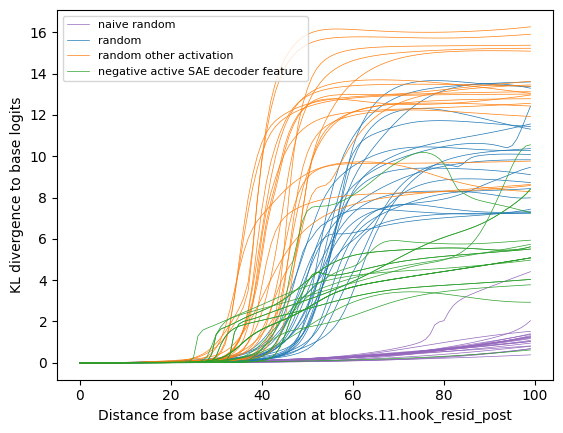

In [282]:
colors = {
    "random": "tab:blue",
    "naive random": "tab:purple",
    "random other activation": "tab:orange",
    "negative active SAE decoder feature": "tab:green",
}

for name in results.keys():
    for i, data in enumerate(results[name]):
        if i == 0:
            # Only label the first line for each perturb_name
            plt.plot(data, color=colors[name], label=name, linewidth=0.5)
        else:
            # Don't label subsequent lines to avoid duplicate legend entries
            plt.plot(data, color=colors[name], linewidth=0.5)

plt.legend(fontsize=8)
plt.ylabel("KL divergence to base logits")
plt.xlabel(f"Distance from base activation at {cfg.read_layer}")
plt.show()

## Analysing perturbation results

In [344]:
def compute_entropy(probs):
    return -torch.sum(probs * torch.log(probs + 1e-10))

In [283]:
print(results.keys())
print(len(results["random"]), results["random"][0].shape)

dict_keys(['naive random', 'random', 'random other activation', 'negative active SAE decoder feature'])
20 torch.Size([100])


In [301]:
sparse_probs = np.exp(sparsities["blocks.1.hook_resid_pre"])

In [351]:
def analyze_feature_activation_dynamics(
    sae, cfg, base_ref, perturbations, act_thresh=0.1
):
    results = []
    for name, perturbation in perturbations.items():
        result = []
        activations = base_ref.act
        n_steps = cfg.n_steps
        direction = perturbation(activations)

        direction -= torch.mean(direction, dim=-1, keepdim=True)
        direction *= torch.linalg.vector_norm(
            activations, dim=-1, keepdim=True
        ) / torch.linalg.vector_norm(direction, dim=-1, keepdim=True)

        # base_features = sae.encode(base_ref.act)
        max_act = 1  # base_features.squeeze().max().item()
        previous_active_features = set()

        perturbed_steps = []

        for alpha in torch.linspace(*cfg.perturbation_range, n_steps):
            perturbed_activations = activations + alpha * direction
            perturbed_features = sae.encode(perturbed_activations)
            current_active_features = set(
                (perturbed_features.squeeze().abs() > (max_act * act_thresh))
                .nonzero()
                .squeeze(-1)
                .tolist()
            )
            new_active_features = current_active_features - previous_active_features
            deactivated_features = previous_active_features - current_active_features
            previous_active_features = current_active_features
            perturbed_steps.append(perturbed_activations)
            mean_feat_act = (
                perturbed_features[
                    ..., (perturbed_features.squeeze().abs() > (max_act * act_thresh))
                ]
                .squeeze()
                .mean()
                .item()
            )
            feature_l2_norm = perturbed_features.norm(p=2).item()

            result.append(
                {
                    "perturbation": name,
                    "alpha": alpha.item(),
                    "current_active_count": len(current_active_features),
                    "new_active_count": len(new_active_features),
                    "deactivated_count": len(deactivated_features),
                    "new_active_features": list(new_active_features),
                    "deactivated_features": list(deactivated_features),
                    "mean_feat_act": mean_feat_act,
                    "feature_l2_norm": feature_l2_norm,
                }
            )

        kl_divs = compare(base_ref, torch.cat(perturbed_steps, dim=0))
        logits_pert, cache = run_perturbed_activation(
            base_ref, torch.cat(perturbed_steps, dim=0)
        )
        kl_divs = compute_kl_div(base_ref.logits, logits_pert)[
            :, base_ref.perturbation_pos
        ].squeeze(-1)

        for i, kl_div in enumerate(kl_divs):
            entropy = compute_entropy(torch.softmax(logits_pert[i, -1, :], dim=-1))
            result[i]["kl_div"] = kl_div.item()
            result[i]["entropy"] = entropy.item()

        results.extend(result)

    return pd.DataFrame(results)

In [352]:
df = analyze_feature_activation_dynamics(
    sae, cfg, base_ref, perturbations, act_thresh=0.0
)

print(df.shape)
df.sample(5)

(400, 11)


,perturbation,alpha,current_active_count,new_active_count,deactivated_count,new_active_features,deactivated_features,mean_feat_act,feature_l2_norm,kl_div,entropy
232,random other activation,0.323232,11,0,0,[],[],2.790229,17.340282,0.956240,5.294148
206,random other activation,0.060606,14,0,0,[],[],3.370359,28.842718,0.004522,3.091354
377,negative active SAE decoder feature,0.777778,3046,116,0,"[19456, 13825, 19974, 3081, 5647, 11792, 21528...",[],1.976233,199.292633,4.907944,3.170125
42,naive random,0.424242,243,22,0,"[7680, 22785, 8197, 11017, 23058, 20116, 13462...",[],1.193686,40.037315,0.099533,3.543443
22,naive random,0.222222,51,8,0,"[9220, 647, 11722, 2764, 18608, 4922, 2941, 5183]",[],1.536541,33.031731,0.021238,3.360855


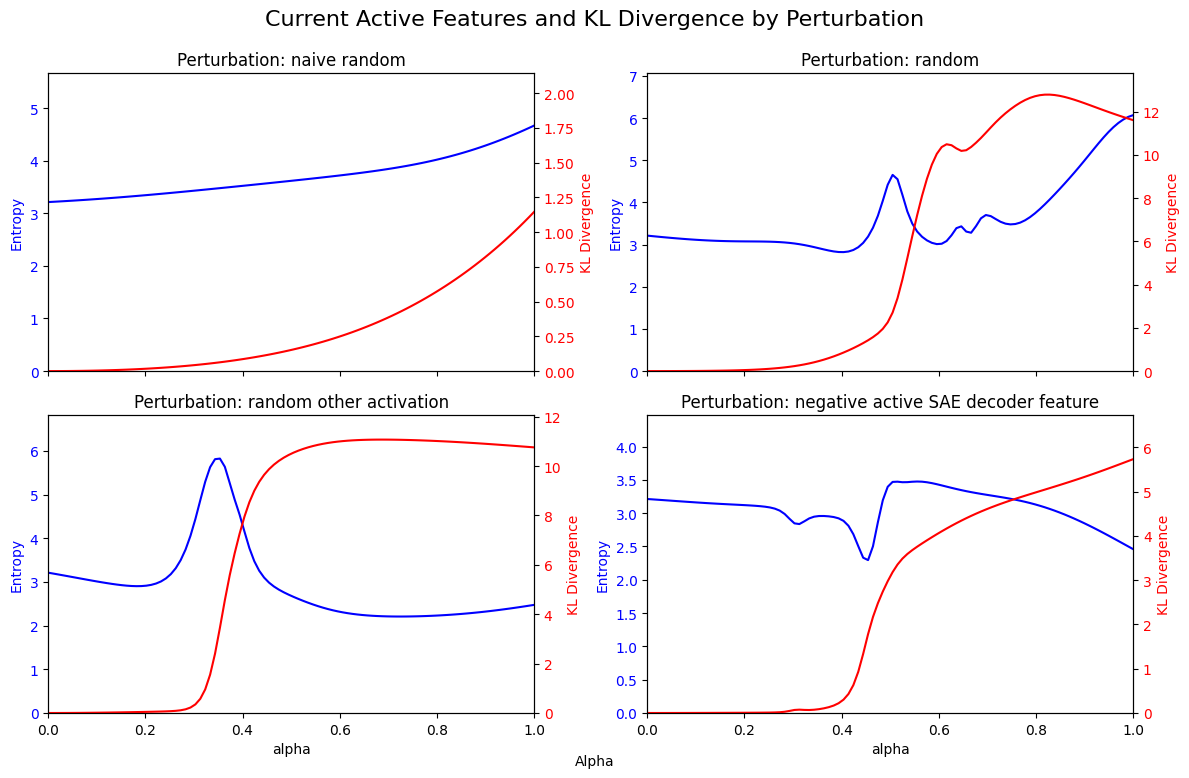

In [355]:
# Calculate grid dimensions
n_plots = len(perturbations)
n_cols = min(2, n_plots)  # Maximum 3 columns
n_rows = math.ceil(n_plots / n_cols)

# Set up the plot
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows), sharex=True, sharey=False
)
fig.suptitle("Current Active Features and KL Divergence by Perturbation", fontsize=16)

# Flatten axes array for easier indexing
axes = axes.flatten() if n_plots > 1 else [axes]

# Create a plot for each perturbation
for i, perturbation in enumerate(perturbations):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # Filter data for this perturbation
    perturb_data = df[df["perturbation"] == perturbation]

    # Plot current_active_count
    # sns.lineplot(x='alpha', y='current_active_count', data=perturb_data, ax=ax1, color='blue', label='Current Active Count')
    # ax1.set_ylabel('Current Active Count', color='blue')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # ax1.set_ylim(0, max(perturb_data['current_active_count']))

    # sns.lineplot(x='alpha', y='mean_feat_act', data=perturb_data, ax=ax1, color='blue', label='Mean Feat Act')
    # ax1.set_ylabel('Mean Feat Act', color='blue')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # ax1.set_ylim(0, max(perturb_data['mean_feat_act']))

    # sns.lineplot(x='alpha', y='feature_l2_norm', data=perturb_data, ax=ax1, color='blue', label='Features L2 Norm')
    # ax1.set_ylabel('Features L2 Norm', color='blue')
    # ax1.tick_params(axis='y', labelcolor='blue')
    # ax1.set_ylim(0, max(perturb_data['feature_l2_norm']))

    sns.lineplot(
        x="alpha", y="entropy", data=perturb_data, ax=ax1, color="blue", label="Entropy"
    )
    ax1.set_ylabel("Entropy", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.set_ylim(0, max(perturb_data["entropy"]) + 1)

    # Plot kl_div
    sns.lineplot(
        x="alpha",
        y="kl_div",
        data=perturb_data,
        ax=ax2,
        color="red",
        label="KL Divergence",
    )
    ax2.set_ylabel("KL Divergence", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(0, max(perturb_data["kl_div"]) + 1)

    # Set title for this subplot
    ax1.set_title(f"Perturbation: {perturbation}")

    # Set x and y axes to start at 0
    ax1.set_xlim(0, max(perturb_data["alpha"]))

    # Remove legends
    ax1.get_legend().remove()
    ax2.get_legend().remove()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a common x-label
fig.text(0.5, 0.04, "Alpha", ha="center", va="center")

# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.1)  # Adjust to prevent title overlap
plt.show()

In [319]:
from scipy.fft import fft

In [320]:
feature_acts = sae.encode(base_ref.act)

In [326]:
fft_result = fft(feature_acts.squeeze().numpy())
power_spectrum = np.abs(fft_result) ** 2

In [327]:
power_spectrum

array([2770.8176 , 1000.4514 ,  511.00464, ...,  781.5673 ,  511.00464,
       1000.4514 ], dtype=float32)

In [ ]:
from sklearn.feature_selection import mutual_info_regression

In [328]:
perturbations.keys()

dict_keys(['naive random', 'random', 'random other activation', 'negative active SAE decoder feature'])

In [372]:
name, perturbation = "random other activation", perturbations["random other activation"]
activations = base_ref.act
n_steps = cfg.n_steps
direction = perturbation(activations)
act_thresh = 0

direction -= torch.mean(direction, dim=-1, keepdim=True)
direction *= torch.linalg.vector_norm(
    activations, dim=-1, keepdim=True
) / torch.linalg.vector_norm(direction, dim=-1, keepdim=True)

# base_features = sae.encode(base_ref.act)
max_act = 1  # base_features.squeeze().max().item()
previous_active_features = set()

perturbed_steps = []

for alpha in torch.linspace(*cfg.perturbation_range, n_steps):
    perturbed_activations = activations + alpha * direction
    perturbed_features = sae.encode(perturbed_activations)
    current_active_features = set(
        (perturbed_features.squeeze().abs() > (max_act * act_thresh))
        .nonzero()
        .squeeze(-1)
        .tolist()
    )
    new_active_features = current_active_features - previous_active_features
    deactivated_features = previous_active_features - current_active_features
    previous_active_features = current_active_features
    perturbed_steps.append(perturbed_activations)
    mean_feat_act = (
        perturbed_features[
            ..., (perturbed_features.squeeze().abs() > (max_act * act_thresh))
        ]
        .squeeze()
        .mean()
        .item(),
    )
    feature_l2_norm = perturbed_features.norm(p=2).item()

logits_pert, cache = run_perturbed_activation(
    base_ref, torch.cat(perturbed_steps, dim=0)
)

In [373]:
perturbed_steps = torch.cat(perturbed_steps, dim=0)

In [364]:
import joypy

In [374]:
data = perturbed_steps.squeeze(1)

In [375]:
data.shape

torch.Size([100, 768])

In [377]:
data.

tensor([[ 0.9749, -2.3652,  1.4243,  ...,  0.8191,  1.0080, -0.7030],
        [ 0.9968, -2.3525,  1.4093,  ...,  0.8285,  0.9962, -0.6827],
        [ 1.0187, -2.3398,  1.3942,  ...,  0.8380,  0.9844, -0.6625],
        ...,
        [ 3.1005, -1.1326, -0.0368,  ...,  1.7357, -0.1369,  1.2610],
        [ 3.1224, -1.1199, -0.0519,  ...,  1.7451, -0.1487,  1.2812],
        [ 3.1443, -1.1072, -0.0669,  ...,  1.7546, -0.1605,  1.3015]])

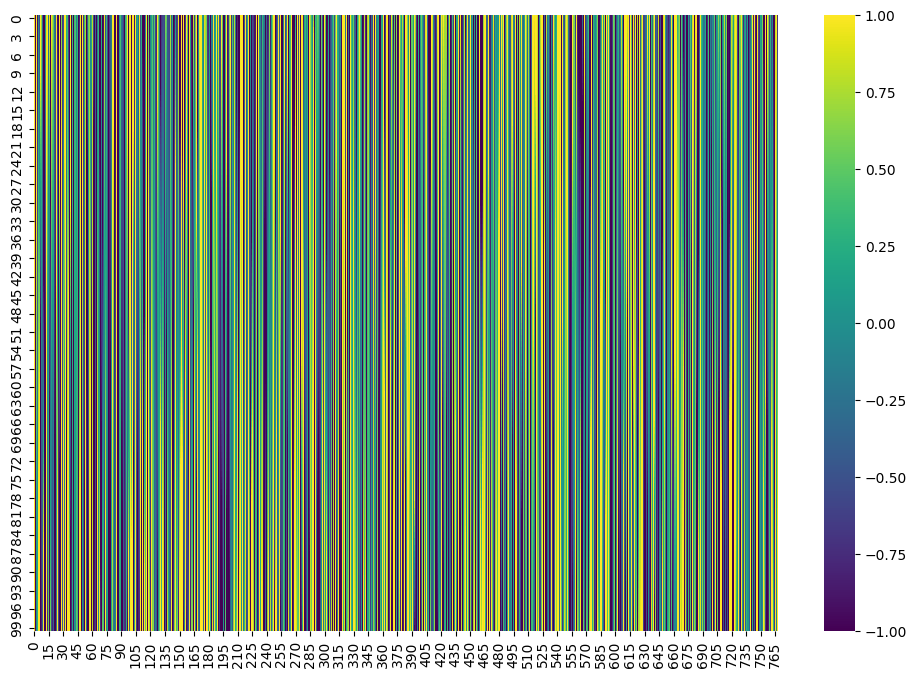

In [383]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.numpy(), cmap="viridis", center=0, vmin=-1, vmax=1)
plt.show()